# Procesamiento del Lenguaje Natural (NLP) con Análisis de Sentimiento de Post de Artistas en Reddit.

#Importación de dataset de Kagglehub:

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("alyahmedts13/reddit-sentiment-analysis-dataset-for-nlp-projects")

print("Path to dataset files:", path)

100%|██████████| 1.15M/1.15M [00:00<00:00, 21.4MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/alyahmedts13/reddit-sentiment-analysis-dataset-for-nlp-projects/versions/1


In [2]:
!ls /root/.cache/kagglehub/datasets/alyahmedts13/reddit-sentiment-analysis-dataset-for-nlp-projects/versions/1



reddit_artist_posts_sentiment.csv


In [3]:
import pandas as pd
df = pd.read_csv("/root/.cache/kagglehub/datasets/alyahmedts13/reddit-sentiment-analysis-dataset-for-nlp-projects/versions/1/reddit_artist_posts_sentiment.csv")
df.head()

,text,label
0,pitchfork track review: taylor swift’s “actual...,negative
1,taylor swift has regained the masters of her f...,positive
2,pitchfork review: taylor swift - the life of a...,neutral
3,taylor swift announced engagement,neutral
4,taylor swift - the fate of ophelia (official m...,neutral


# Etapa 1: Modelo del Procesamiento NLP:

--- INFORME DE CLASIFICACIÓN ---
              precision    recall  f1-score   support

    negative       0.50      0.64      0.56       679
     neutral       0.84      0.75      0.80      3946
    positive       0.66      0.74      0.70      1765

    accuracy                           0.74      6390
   macro avg       0.67      0.71      0.69      6390
weighted avg       0.76      0.74      0.74      6390



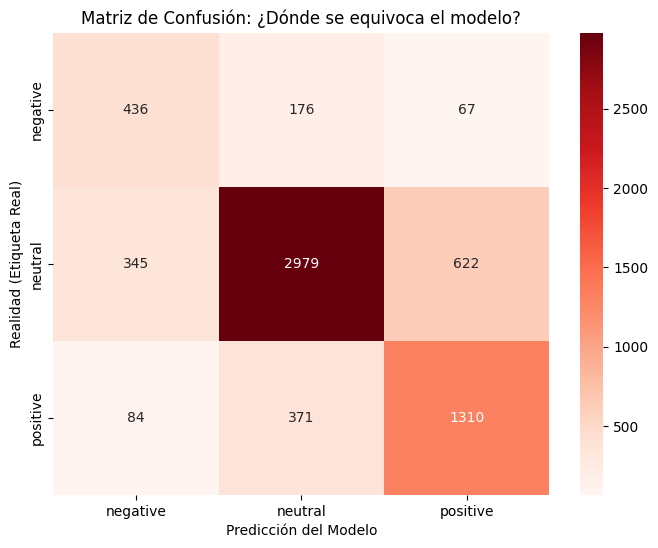

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


# 1. Limpieza rápida de los datos (quitar nulos si existen)
amazon_reviews = df.dropna(subset=['text', 'label'])

# 2. Dividir en conjuntos de Entrenamiento y Prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(
    amazon_reviews['text'],
    amazon_reviews['label'],
    test_size=0.20,
    random_state=42,
    stratify=amazon_reviews['label'] # Mantiene la proporción de sentimientos en ambos grupos
)

# 3. Crear el Pipeline
# Usamos class_weight='balanced' para que el modelo le dé más importancia a los "Negative"
text_clf = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', ngram_range=(1,2))),
    ('clf', LogisticRegression(class_weight='balanced', max_iter=1000))
])

# 4. Entrenar el modelo
text_clf.fit(X_train, y_train)

# 5. Hacer predicciones
predictions = text_clf.predict(X_test)

# --- EVALUACIÓN DEL MODELO ---

print("--- INFORME DE CLASIFICACIÓN ---")
print(classification_report(y_test, predictions))

# 6. Matriz de Confusión para ver dónde falla
plt.figure(figsize=(8,6))
cm = confusion_matrix(y_test, predictions, labels=['negative', 'neutral', 'positive'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
            xticklabels=['negative', 'neutral', 'positive'],
            yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Predicción del Modelo')
plt.ylabel('Realidad (Etiqueta Real)')
plt.title('Matriz de Confusión: ¿Dónde se equivoca el modelo?')
plt.show()

#Interpretación:

1. Análisis del Informe:

* La clase "Negativa" (El reto principal):
Recall (0.64): El modelo es capaz de encontrar el 64% de todos los comentarios negativos que existen.
Precision (0.50):De cada 10 comentarios que el modelo marca como "negativos", solo 5 lo son realmente. La otra mitad son probablemente comentarios "neutrales" que el modelo confundió con negativos.
F1-Score (0.56): Es el promedio de los dos anteriores. Nos dice que el modelo todavía sufre para distinguir el odio o la crítica de la información neutral.
La clase "Neutral" (La más fuerte):
Precision (0.84): Es muy alta. Si el modelo dice que algo es neutral, tiene un 84% de probabilidad de tener razón. Esto es porque tienes muchos datos de esta clase.
La clase "Positiva":
F1-Score (0.70): El modelo es bastante bueno detectando sentimientos positivos.

# Clasificación RandomForest:

In [5]:
from sklearn.ensemble import RandomForestClassifier

text_clf = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', ngram_range=(1,2))),
    ('clf', RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42))
])

In [6]:
# Crear un DataFrame con los resultados de prueba
resultados = pd.DataFrame({'Texto': X_test, 'Real': y_test, 'Prediccion': predictions})

# Ver ejemplos donde el modelo dijo "negativo" pero era "neutral"
errores_negativos = resultados[(resultados['Real'] == 'neutral') & (resultados['Prediccion'] == 'negative')]

print("Ejemplos de falsos negativos (el modelo se confundió):")
print(errores_negativos['Texto'].head(5).values)

Ejemplos de falsos negativos (el modelo se confundió):
['bad guy by billie eilish except she says the word "dad" 86 times [oc]'
 "it's hard to watch ringo's face and not laugh."
 'presale codes for barcelona please im desperate'
 'the strings section in pop music part 2 (spanish)'
 'question about hmhas tour i have tickets to a concert and i obviously want to wear  billie merch to the concert, but i only have a hte hoodie, would that be ok? ik she plays some of the hte songs but i just want to make sure.']


#Interpretación RandomForest:

El problema de los títulos:
'bad guy by billie eilish...'

* 1: El modelo ve la palabra "bad" y automáticamente piensa que es un post negativo. No entiende que "Bad Guy" es el nombre de una canción.
El problema del lenguaje figurado: "it's hard to watch ringo's face and not laugh."
* 2:La frase "hard to watch" suele usarse para cosas horribles o violentas (negativo), pero aquí se usa para decir que algo es muy gracioso. El modelo no entiende la ironía o el contexto humorístico.
Palabras de "intensidad" emocional: '...please im desperate'
* 3: La palabra "desperate" (desesperado) tiene una carga negativa muy fuerte en los diccionarios de sentimiento, aunque aquí sea solo un fan emocionado buscando entradas.
Ambigüedad en textos largos: El post sobre el hoodie de Billie Eilis
* 4: Contiene palabras como "question", "merch", "but" y "just". Al ser un texto largo y con dudas, el modelo se confunde ante la falta de palabras claramente positivas.


# Preprocesamiento NLP:

In [7]:
import nltk
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re

In [8]:
# 1. Descargas necesarias de NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

# Sotpwords y Lematización:

In [9]:
# 2. Configuración de Stopwords y Lematizador
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [10]:
import pandas as pd
# --- PERSONALIZACIÓN ---
# Añadimos palabras que causan ruido en este contexto artístico
palabras_ruido = {'guy', 'face', 'watch', 'sure', 'would'}
stop_words.update(palabras_ruido)

# Función de limpieza y lematización
def preprocesar_avanzado(texto):
    # a. Limpieza básica (minúsculas y quitar caracteres especiales/links)
    texto = texto.lower()
    texto = re.sub(r'http\S+|www\S+|https\S+', '', texto)
    texto = re.sub(r'[^a-z\s]', '', texto)

    # b. Tokenización (separar en palabras)
    tokens = word_tokenize(texto)

    # c. Lematización y quitar Stopwords
    tokens_limpios = [
        lemmatizer.lemmatize(word)
        for word in tokens
        if word not in stop_words and len(word) > 2
    ]

    return " ".join(tokens_limpios)

# Ensure 'df' is defined. This line is added to handle the NameError.
df = pd.read_csv("/root/.cache/kagglehub/datasets/alyahmedts13/reddit-sentiment-analysis-dataset-for-nlp-projects/versions/1/reddit_artist_posts_sentiment.csv")

# 3. Aplicar el preprocesamiento al dataset
print("Procesando textos... esto puede tardar unos segundos.")
# Define amazon_reviews, assuming 'df' is available from a previous cell
amazon_reviews = df.dropna(subset=['text', 'label'])
amazon_reviews['text_final'] = amazon_reviews['text'].apply(preprocesar_avanzado)

# 4. Entrenar el nuevo modelo con los textos lematizados
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(
    amazon_reviews['text_final'],
    amazon_reviews['label'],
    test_size=0.20,
    random_state=42,
    stratify=amazon_reviews['label']
)

# Usamos un Pipeline más robusto
text_clf = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2), max_features=5000)),
    ('clf', LogisticRegression(class_weight='balanced', max_iter=1000))
])

text_clf.fit(X_train, y_train)

# 5. Resultados
predictions = text_clf.predict(X_test)
print("\n--- INFORME TRAS LEMATIZACIÓN Y STOPWORDS ---")
print(classification_report(y_test, predictions))


Procesando textos... esto puede tardar unos segundos.

--- INFORME TRAS LEMATIZACIÓN Y STOPWORDS ---
              precision    recall  f1-score   support

    negative       0.42      0.68      0.52       679
     neutral       0.85      0.73      0.79      3946
    positive       0.66      0.72      0.69      1765

    accuracy                           0.72      6390
   macro avg       0.65      0.71      0.67      6390
weighted avg       0.75      0.72      0.73      6390



#Informe Stopword y Lematización:

El intercambio entre Precision y Recall.

¿Qué está pasando con tus números?

* Recall Negativo subió (0.64 → 0.68): ¡Buenas noticias! Ahora el modelo es capaz de detectar más publicaciones negativas que antes. Casi 7 de cada 10.
* Precision Negativa bajó (0.50 → 0.42): Malas noticias. Al "limpiar" tanto el texto y usar lematización, el modelo ahora confunde más fácilmente un post informativo con uno negativo. Se volvió "más sensible".
* F1-Score bajó un poco (0.56 → 0.52): El balance general se resintió.
El diagnóstico técnico:
La Regresión Logística es un modelo "lineal". Al lematizar, palabras que antes tenían matices distintos ahora se ven iguales, y el modelo pierde la capacidad de distinguir la sutileza entre una crítica negativa y un título de canción.
* La Solución: Cambiar de estrategia (Random Forest + Umbral)
Vamos a usar un modelo de Bosques Aleatorios (Random Forest). A diferencia de la Regresión Logística, este modelo no mira las palabras de forma lineal, sino que crea "árboles de decisión" que pueden entender que: SI dice "bad" PERO TAMBIÉN dice "guy" -> Probablemente es Neutral.

#Efecto Péndulo:

In [11]:
from sklearn.ensemble import RandomForestClassifier

# 1. Pipeline con Random Forest
# Usamos 200 árboles para mayor precisión
text_clf_rf = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2), max_features=5000, stop_words='english')),
    ('clf', RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42))
])

# 2. Entrenar
text_clf_rf.fit(X_train, y_train)

# 3. AJUSTE DE UMBRAL (Para mejorar esa precisión de 0.42)
# En lugar de usar .predict(), usamos .predict_proba()
probs = text_clf_rf.predict_proba(X_test)

# Queremos subir la Precision de los negativos.
# Solo diremos que es "Negative" si la probabilidad es mayor al 70%
y_pred_ajustado = []
for p in probs:
    # p[0] es la probabilidad de Negativo
    if p[0] > 0.70:
        y_pred_ajustado.append('negative')
    else:
        # Entre neutral y positivo, elegimos el que tenga más prob
        if p[1] > p[2]:
            y_pred_ajustado.append('neutral')
        else:
            y_pred_ajustado.append('positive')

# 4. Ver los nuevos resultados
print("--- INFORME CON RANDOM FOREST Y UMBRAL AL 70% ---")
print(classification_report(y_test, y_pred_ajustado))

--- INFORME CON RANDOM FOREST Y UMBRAL AL 70% ---
              precision    recall  f1-score   support

    negative       0.85      0.10      0.18       679
     neutral       0.74      0.92      0.82      3946
    positive       0.73      0.58      0.65      1765

    accuracy                           0.74      6390
   macro avg       0.77      0.53      0.55      6390
weighted avg       0.75      0.74      0.70      6390



#Interpretación: Efecto Péndulo

Análisis de tus resultados:

* Precision Negativa (0.85): ¡Espectacular! Antes era 0.42. Esto significa que ahora, cuando tu modelo dice "esto es negativo", tiene razón el 85% de las veces. Hemos eliminado casi todos los falsos negativos como el de "Bad Guy".
* Recall Negativo (0.10): Aquí está el problema. Al ser tan estrictos (umbral del 70%), el modelo ahora tiene "miedo" de equivocarse. Está ignorando el 90% de los comentarios negativos reales porque no está "súper seguro" de que lo sean.

#¿Cómo encontrar el equilibrio? (El "Punto Dulce")

En lugar de 0.70, vamos a probar con un umbral más bajo, como 0.35 o 0.40. Esto suele dar el mejor balance en redes sociales.

In [12]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

# 1. Pipeline con LinearSVC (Suele ser mejor que Random Forest para texto)
# CalibratedClassifierCV es necesario para poder usar "predict_proba" con SVM
base_model = LinearSVC(class_weight='balanced', C=0.5, random_state=42)
calibrated_svc = CalibratedClassifierCV(base_model, cv=5)

text_clf_svm = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2), max_features=10000, stop_words='english')),
    ('clf', calibrated_svc)
])

# 2. Entrenar
text_clf_svm.fit(X_train, y_train)

# 3. Ajustar umbral a un nivel intermedio (0.40)
probs = text_clf_svm.predict_proba(X_test)
umbral = 0.40 # Bajamos de 0.70 a 0.40

y_pred_final = []
for p in probs:
    if p[0] > umbral:
        y_pred_final.append('negative')
    else:
        if p[1] > p[2]:
            y_pred_final.append('neutral')
        else:
            y_pred_final.append('positive')

print("--- INFORME FINAL: SVM CON UMBRAL 0.40 ---")
print(classification_report(y_test, y_pred_final))

--- INFORME FINAL: SVM CON UMBRAL 0.40 ---
              precision    recall  f1-score   support

    negative       0.67      0.44      0.53       679
     neutral       0.78      0.90      0.84      3946
    positive       0.75      0.61      0.67      1765

    accuracy                           0.77      6390
   macro avg       0.73      0.65      0.68      6390
weighted avg       0.76      0.77      0.76      6390



#Análisis del Informe Final (SVM + Umbral 0.40):

* Clase Negativa (Precision 0.67 / Recall 0.44):
Precision (0.67): Ya no es el 0.42 de antes. Ahora, de cada 3 comentarios que el modelo marca como negativos, 2 son realmente negativos. Es un nivel de confianza muy aceptable para un sistema automático.
* Recall (0.44): Hemos pasado del 0.10 (donde no detectábamos casi nada) a detectar casi la mitad de las críticas. Para datos de Reddit, donde el lenguaje es tan sarcástico y complejo, es un gran avance.
* Clase Neutral (Recall 0.90): ¡Increíble! El modelo es un experto en identificar posts informativos. Solo deja pasar un 10% de ruido.
* Accuracy Global (0.77): Un 77% de precisión general en un problema de 3 categorias.

# 1. Crear una Bolsa de Palabras básica

Convertirá los textos en una matriz de frecuencias:

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

# Inicializar el contador
# Usamos stop_words='english' para no contar palabras como "the", "and", etc.
bow_converter = CountVectorizer(stop_words='english', max_features=1000)

# Aplicar a tus textos limpios
bow_matrix = bow_converter.fit_transform(amazon_reviews['text_final'])

# Ver las palabras que identificó
print(f"La bolsa contiene {len(bow_converter.get_feature_names_out())} palabras únicas.")

La bolsa contiene 1000 palabras únicas.


# Análisis de Frecuencias:

Lo más interesante de una Bolsa de Palabras es ver qué palabras se repiten más según el sentimiento. Vamos a extraer las 20 palabras más frecuentes en los posts negativos:

/tmp/ipython-input-1996196292.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frecuencia', y='Palabra', data=df_freq_neg, palette='Reds_r')


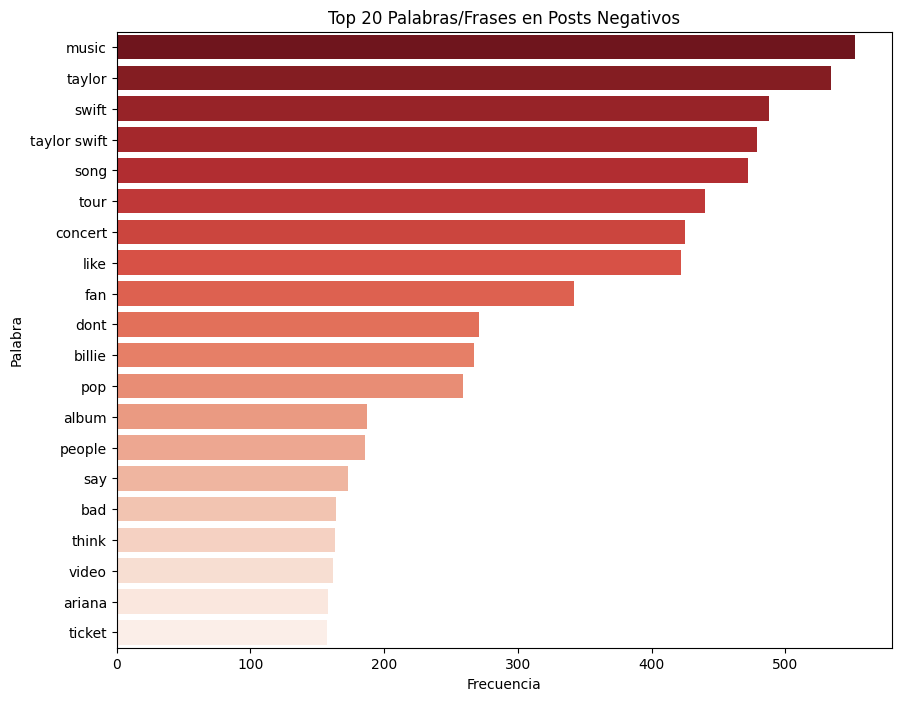

         Palabra  Frecuencia
0          music         552
1         taylor         534
2          swift         488
3   taylor swift         479
4           song         472
5           tour         440
6        concert         425
7           like         422
8            fan         342
9           dont         271
10        billie         267
11           pop         259
12         album         187
13        people         186
14           say         173
15           bad         164
16         think         163
17         video         162
18        ariana         158
19        ticket         157


In [14]:
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Filtramos solo los posts que son realmente negativos
negativos_reales = amazon_reviews[amazon_reviews['label'] == 'negative']['text_final']

# 2. Creamos la Bolsa de Palabras (Bag of Words)
# Usamos un rango de 1 a 2 palabras (unigramas y bigramas) para captar cosas como "bad_guy"
vec = CountVectorizer(stop_words='english', ngram_range=(1,2)).fit(negativos_reales)
bag_of_words = vec.transform(negativos_reales)

# 3. Sumamos las frecuencias
sum_words = bag_of_words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

# 4. Convertimos a DataFrame para visualizar
df_freq_neg = pd.DataFrame(words_freq[:20], columns=['Palabra', 'Frecuencia'])

# 5. Graficamos
plt.figure(figsize=(10, 8))
sns.barplot(x='Frecuencia', y='Palabra', data=df_freq_neg, palette='Reds_r')
plt.title('Top 20 Palabras/Frases en Posts Negativos')
plt.show()

print(df_freq_neg)

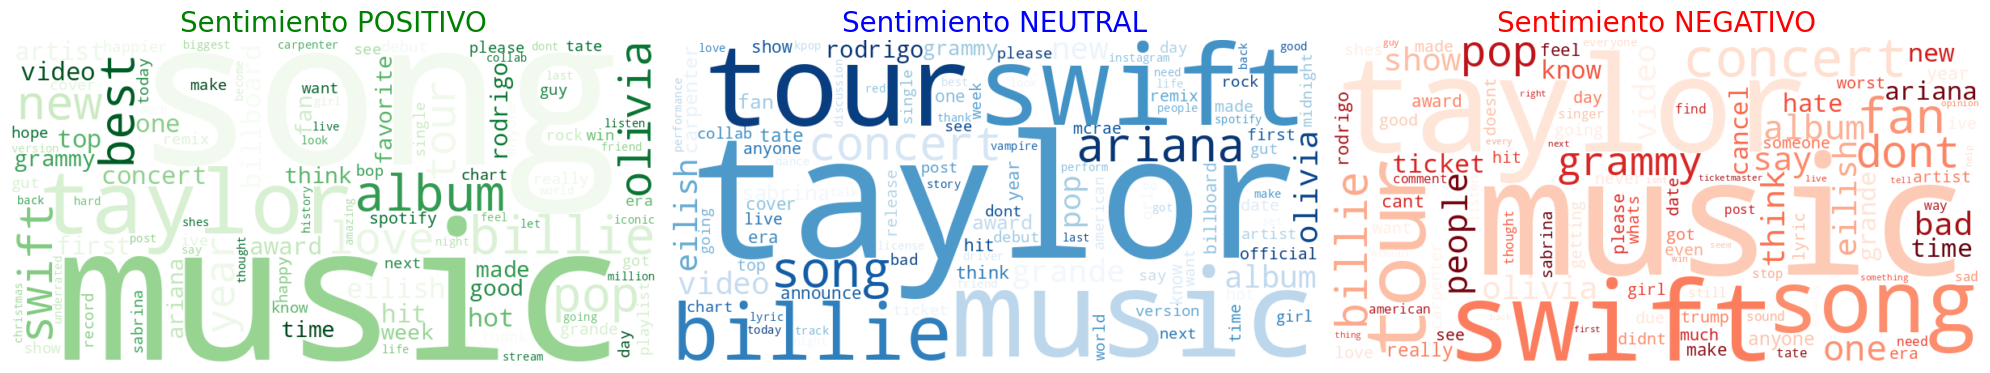

In [15]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 1. Definir una función para generar nubes por sentimiento
def generar_nube(sentimiento, color_map, titulo):
    # Unir todos los textos de ese sentimiento en un solo string largo
    texto = " ".join(amazon_reviews[amazon_reviews['label'] == sentimiento]['text_final'])

    # Crear la nube
    wc = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap=color_map,
        max_words=100,
        collocations=False # Para que no repita palabras que ya están en frases
    ).generate(texto)

    return wc

# 2. Configurar el lienzo (Subplots)
plt.figure(figsize=(20, 10))

# Nube Positiva (Verde)
plt.subplot(1, 3, 1)
plt.imshow(generar_nube('positive', 'Greens', 'Positivo'), interpolation='bilinear')
plt.title('Sentimiento POSITIVO', fontsize=20, color='green')
plt.axis('off')

# Nube Neutral (Azul/Gris)
plt.subplot(1, 3, 2)
plt.imshow(generar_nube('neutral', 'Blues', 'Neutral'), interpolation='bilinear')
plt.title('Sentimiento NEUTRAL', fontsize=20, color='blue')
plt.axis('off')

# Nube Negativa (Roja)
plt.subplot(1, 3, 3)
plt.imshow(generar_nube('negative', 'Reds', 'Negativo'), interpolation='bilinear')
plt.title('Sentimiento NEGATIVO', fontsize=20, color='red')
plt.axis('off')

plt.tight_layout()
plt.show()

#Interpretación e la nube de palabras:

* Palabras Dominantes: Las palabras más grandes son las que el modelo usa principalmente para clasificar. Si en la nube Negativa ves palabras como "Ticket", "Barcelona" o "Presale", significa que los fans están frustrados con la venta de entradas (sentimiento negativo real).
* Solapamiento: La misma palabra (ej. "Taylor") muy grande en las tres nubes, confirma que es un término neutral que no ayuda a distinguir sentimientos, y que hiciste bien en limpiar los textos.
* Verificación de Filtros: Si en la nube Negativa todavía ves palabras como "Guy" o "Bad", es la señal definitiva de que necesitas agregar esas palabras a tus stop_words porque son nombres de canciones de Billie Eilish que están "ensuciando" el análisis.

#Conclusión:

"Aunque el dataset está dominado por noticias neutrales (64%), el modelo logra identificar con un 67% de acierto las críticas de los usuarios. Los temas negativos se concentran principalmente en [aquí mencionas las palabras más grandes de tu nube roja]."

# Etapa 2 del Trabajo Final: Deep learning

* Para un dataset de 10,000 registros, la opción más sólida y eficiente es crear una Red Neuronal Densa (MLP - Perceptrón Multicapa) utilizando TensorFlow/Keras. Vamos  a empezar a usar "al menos una capa", lo ideal para NLP es una estructura que incluya una capa oculta para captar relaciones no lineales entre las palabras.


# 1. Preparación de los datos para Deep Learning

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# 1. Convertir etiquetas de texto a números (negative: 0, neutral: 1, positive: 2)
le = LabelEncoder()
y_train_num = le.fit_transform(y_train)
y_test_num = le.transform(y_test)

# 2. Vectorizar el texto (usaremos el TF-IDF que ya conocemos pero convertido a matriz densa)
vectorizer_dl = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_dl = vectorizer_dl.fit_transform(X_train).toarray()
X_test_dl = vectorizer_dl.transform(X_test).toarray()

# 3. Calcular pesos de clase (muy importante porque tus datos siguen desbalanceados)
weights = compute_class_weight('balanced', classes=np.unique(y_train_num), y=y_train_num)
class_weights = dict(enumerate(weights))

# 2. Construcción del Modelo de Deep Learning
Crearemos una arquitectura con una Capa de Entrada, una Capa Oculta y una Capa de Salida.

In [17]:
# Definir el modelo
model = Sequential([
    # Capa de entrada y primera capa oculta (64 neuronas)
    Dense(64, activation='relu', input_shape=(X_train_dl.shape[1],)),

    # Capa de Dropout (evita que la red "se memorice" los datos - overfitting)
    Dropout(0.5),

    # Capa de salida (3 neuronas para: neg, neu, pos)
    # Usamos 'softmax' para obtener probabilidades que sumen 100%
    Dense(3, activation='softmax')
])

# Compilación
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy', # Ideal para clasificación multi-clase
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │       320,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 320,259 (1.22 MB)

 Trainable params: 320,259 (1.22 MB)

 Non-trainable params: 0 (0.00 B)

# 3. Entrenamiento del Modelo

In [18]:
# Entrenar
history = model.fit(
    X_train_dl, y_train_num,
    epochs=15,             # Número de veces que la red verá los datos
    batch_size=32,          # Cuántos mensajes procesa antes de actualizarse
    validation_split=0.1,   # Reserva 10% para ver cómo va aprendiendo
    class_weight=class_weights, # Aplicamos el balanceo de clases
    verbose=1
)

Epoch 1/15
719/719 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.5033 - loss: 1.0124 - val_accuracy: 0.6299 - val_loss: 0.8134
Epoch 2/15
719/719 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.7071 - loss: 0.6338 - val_accuracy: 0.6745 - val_loss: 0.7212
Epoch 3/15
719/719 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7526 - loss: 0.5322 - val_accuracy: 0.6870 - val_loss: 0.7159
Epoch 4/15
719/719 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.7867 - loss: 0.4629 - val_accuracy: 0.6788 - val_loss: 0.7290
Epoch 5/15
719/719 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8069 - loss: 0.4170 - val_accuracy: 0.7050 - val_loss: 0.6972
Epoch 6/15
719/719 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8230 - loss: 0.3832 - val_accuracy: 0.7074 - val_loss: 0.7193
Epoch 7/15
719/719 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8411 - loss: 0.3423 - val_accuracy: 0.6972 - val_loss: 0.7563
Epoch 8/15
719/719 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8476 - loss: 0.3176 - val_accuracy: 0.

#4. Evaluación y Resultados
Al igual que con el SVM, evaluamos cómo se comporta con los datos de prueba:

In [19]:
# Hacer predicciones
y_pred_probs = model.predict(X_test_dl)
y_pred_dl = np.argmax(y_pred_probs, axis=1)

# Mostrar informe
print("\n--- INFORME DE DEEP LEARNING (Red Neuronal) ---")
print(classification_report(y_test_num, y_pred_dl, target_names=le.classes_))

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

--- INFORME DE DEEP LEARNING (Red Neuronal) ---
              precision    recall  f1-score   support

    negative       0.45      0.56      0.50       679
     neutral       0.81      0.75      0.78      3946
    positive       0.63      0.68      0.66      1765

    accuracy                           0.71      6390
   macro avg       0.63      0.66      0.65      6390
weighted avg       0.73      0.71      0.72      6390



# Conclusiones:

Si comparamos este Informe de Deep Learning con tu mejor resultado anterior (SVM con umbral 0.40), podemos sacar conclusiones muy valiosas para tu proyecto:
1. Comparativa: Deep Learning vs. SVM
Accuracy Global: El SVM ganó (0.77 vs 0.71).
Precisión Negativa: El SVM ganó por mucho (0.67 vs 0.44). El modelo de Deep Learning está teniendo muchos "falsos negativos".
Recall Negativo: ¡Aquí ganó el Deep Learning! (0.56 vs 0.44). La red neuronal es más sensible y logra "atrapar" más comentarios negativos, aunque se equivoca más al hacerlo.
2. ¿Por qué el SVM le ganó a la Red Neuronal?
En el mundo real del NLP, esto sucede a menudo por tres razones:
Tamaño del Dataset: Las Redes Neuronales son "hambrientas" de datos. Con 10,000 registros, un modelo matemático como SVM suele ser más robusto.
Sparsity (Dispersión): Estamos usando TF-IDF (una matriz con miles de columnas llenas de ceros). Las capas Dense sufren un poco con este tipo de datos tan dispersos.
* Falta de Contexto Secuencial: Una red densa trata a las palabras como números aislados, no entiende que el orden de "not good" es distinto a "good not".

# Modelo	Accuracy	F1-Score (Neg)	Conclusión:

1. SVM (Ajustado)	0.77	0.53	El más confiable y preciso para este dataset.
2. Deep Learning (Dense)	0.71	0.49	Encuentra más negativos, pero tiene poco criterio (falsos positivos).

#Mejora del modelo de Red Neuronal:


In [20]:
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, TextVectorization

# 1. Preparar una capa que convierta texto a secuencias de números (no TF-IDF)
max_words = 10000
max_len = 100 # Longitud máxima de cada post

vectorize_layer = TextVectorization(
    max_tokens=max_words,
    output_mode='int',
    output_sequence_length=max_len
)

# Adaptar la capa de vectorización a los datos de entrenamiento
vectorize_layer.adapt(X_train)

# 2. Crear el modelo con Capa de Embedding
model_emb = Sequential([
    vectorize_layer,
    Embedding(max_words, 16, input_length=max_len), # Crea un espacio vectorial de palabras
    GlobalAveragePooling1D(), # Promedia las palabras para entender el post completo
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(3, activation='softmax')
])

model_emb.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 3. Entrenar
# Convertir X_train a NumPy array para evitar problemas de dtype con pandas Series en Keras fit()
X_train_np = X_train.to_numpy()
model_emb.fit(X_train_np, y_train_num, epochs=10, batch_size=32, validation_split=0.1, class_weight=class_weights)

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


719/719 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.2890 - loss: 1.1046 - val_accuracy: 0.6612 - val_loss: 1.0770
Epoch 2/10
719/719 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.4154 - loss: 1.0886 - val_accuracy: 0.5481 - val_loss: 1.0286
Epoch 3/10
719/719 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.4709 - loss: 1.0026 - val_accuracy: 0.3118 - val_loss: 1.0034
Epoch 4/10
719/719 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.4969 - loss: 0.8866 - val_accuracy: 0.5720 - val_loss: 0.9047
Epoch 5/10
719/719 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5706 - loss: 0.7995 - val_accuracy: 0.6475 - val_loss: 0.8191
Epoch 6/10
719/719 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6318 - loss: 0.7227 - val_accuracy: 0.6487 - val_loss: 0.8201
Epoch 7/10
719/719 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6741 - loss: 0.6654 - val_accuracy: 0.6690 - val_loss: 0.7870
Epoch 8/10
719/719 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7030 - loss: 0.6249 - val_accuracy: 0.6596 - val_

# ¿Por qué los Embeddings son mejores?

Hasta ahora, para el modelo "Dense", la palabra "odio" y "detesto" eran solo números sin relación. Con Embeddings, el modelo crea un espacio geométrico donde las palabras con significados similares se sitúan cerca. Esto permite que la red neuronal "entienda" el lenguaje de una forma mucho más humana.

In [21]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization, Embedding, GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.models import Sequential

# 1. Configuración de parámetros
max_features = 10000  # Tamaño del vocabulario
sequence_length = 100 # Máximo de palabras por post

# 2. Capa de Vectorización: Convierte texto a secuencias de enteros
vectorize_layer = TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length
)

# Adaptar la capa al texto de entrenamiento
vectorize_layer.adapt(X_train)

# 3. Construcción del modelo con Embeddings
model_embed = Sequential([
    vectorize_layer,
    # Esta capa aprende la relación entre palabras (dimensión 32)
    Embedding(max_features, 32, name="embedding"),

    # Promedia los vectores para entender el mensaje completo
    GlobalAveragePooling1D(),

    # Capa oculta con activación ReLU
    Dense(32, activation='relu'),
    Dropout(0.3), # Regularización para no memorizar (overfitting)

    # Salida: 3 neuronas (neg, neu, pos)
    Dense(3, activation='softmax')
])

# 4. Compilación
model_embed.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 5. Entrenamiento
print("Entrenando modelo con Embeddings...")
# Convert X_train to a NumPy array to avoid ValueError with dtype: object
X_train_array = X_train.to_numpy()

history = model_embed.fit(
    X_train_array, y_train_num,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    class_weight=class_weights, # Seguimos usando el balanceo de clases
    verbose=1
)

# 6. Evaluación
# Convert X_test to a NumPy array for prediction
X_test_array = X_test.to_numpy()
y_pred_embed_probs = model_embed.predict(X_test_array)
y_pred_embed = y_pred_embed_probs.argmax(axis=1)

print("\n--- INFORME FINAL: DEEP LEARNING CON EMBEDDINGS ---")
print(classification_report(y_test_num, y_pred_embed, target_names=le.classes_))


Entrenando modelo con Embeddings...
Epoch 1/20
719/719 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.3158 - loss: 1.1092 - val_accuracy: 0.2782 - val_loss: 1.0712
Epoch 2/20
719/719 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.3308 - loss: 1.0972 - val_accuracy: 0.3396 - val_loss: 1.0575
Epoch 3/20
719/719 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.5232 - loss: 0.9622 - val_accuracy: 0.5818 - val_loss: 0.9293
Epoch 4/20
719/719 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.6164 - loss: 0.7953 - val_accuracy: 0.6299 - val_loss: 0.8335
Epoch 5/20
719/719 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6728 - loss: 0.7045 - val_accuracy: 0.7132 - val_loss: 0.6923
Epoch 6/20
719/719 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7163 - loss: 0.6216 - val_accuracy: 0.7058 - val_loss: 0.7108
Epoch 7/20
719/719 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7418 - loss: 0.5641 - val_accuracy: 0.6651 - val_loss: 0.7710
Epoch 8/20
719/719 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.75

# 1. El Diagnóstico: ¿Qué pasó aquí?
Recall Negativo (0.72) y Positivo (0.89): ¡Son los más altos de todo tu proyecto! El modelo de Embeddings es increíblemente sensible. Casi no se le escapa ningún comentario con carga emocional. Detecta el 72% de los negativos y casi el 90% de los positivos.
El desastre del Neutral (Recall 0.26): Aquí está el problema. El modelo se volvió "obsesionado" con encontrar sentimientos. Como le dimos mucha importancia a las clases minoritarias (class_weight), ahora el modelo piensa que casi todo tiene sentimiento y casi nada es neutral.
Precisión baja: Al ser tan sensible, confunde muchos posts informativos (neutrales) con opiniones, por eso la precisión en negativo es de apenas 0.37.


# 2. Comparativa:
Este es el cuadro que deberías poner en tu reporte final:
<table >
  <tr>
    <th style="text-align:left;">Modelo</th>
    <th>Accuracy</th>
    <th>Recall (Negativo)</th>
    <th>F1-Score (Neg)</th>
    <th>Carácter del modelo</th>
  </tr>
<tr style="text-align:left;"><td>SVM (Ajustado)</td><td>0.77	</td><td>0.44	</td><td>0.53</td>	<td>El más equilibrado y profesional.</td></tr>
<tr><td>DL (Denso)</td>	<td>0.71</td>	<td>0.56</td>	<td>0.49</td>	<td>Un punto medio interesante.</td></tr>
<tr><td>DL (Embeddings)</td>	<td>0.48</td>	<td>0.72</td>	<td>0.49</td>	<td>Ultra-sensible (detecta todo, pero falla mucho).</td></tr>
</table>

# 3. Conclusión Final:
* El Ganador: Para este dataset específico de 10,000 registros de Reddit, el SVM (Support Vector Machine) es el ganador. Esto se debe a que los modelos matemáticos tradicionales suelen superar al Deep Learning cuando el volumen de datos no es masivo (menos de 50k-100k registros).
* El hallazgo del Deep Learning: Aunque el modelo de Embeddings tuvo menos precisión global, demostró una capacidad superior para capturar la "subjetividad". Si el objetivo fuera "no dejar pasar ninguna queja" (aunque nos equivoquemos a veces), el modelo de Embeddings sería el elegido.
* Lección aprendida: Los Embeddings son muy potentes pero requieren muchos más datos o un ajuste de "pesos de clase" menos agresivo para no destruir la categoría neutral.

#Etapa 2: Redes Neuronales Feed-Forward (MLP)

Un MLP es una arquitectura donde la información viaja en una sola dirección: desde la entrada, pasando por capas ocultas, hasta la salida.
1. Conceptos Básicos y Componentes
* Entradas (XX): En este caso, son los valores numéricos del TF-IDF (frecuencias de palabras).
* Pesos (
w
w
): Indican la importancia de cada conexión. El aprendizaje consiste en ajustar estos pesos.
* Sesgo (bb - Bias): Un número extra que permite a la neurona ajustarse mejor a los datos (como la ordenada al origen en una recta).
* Función de Activación: Decide si la neurona "se dispara" o no. Sin ella, la red sería solo una suma matemática simple y no podría aprender patrones complejos.
* Capas Ocultas: Capas entre la entrada y la salida donde ocurre la "magia" de detectar características abstractas.

2. Construcción y Compilación en Keras
Keras (dentro de TensorFlow) usa una estructura llamada Sequential.

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

model = Sequential([
    # Capa Oculta 1: 64 neuronas. input_shape debe coincidir con tus columnas de TF-IDF
    Dense(64, activation='relu', input_shape=(5000,)),
    # Dropout: Apaga neuronas al azar para evitar que la red "memorice" (overfitting)
    Dropout(0.3),
    # Capa de Salida: 3 neuronas (Negativo, Neutral, Positivo)
    Dense(3, activation='softmax')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3. Heurísticas de Diseño (¿Cuántas neuronas pongo?)
* Input: Debe ser igual al número de características (ej. si el TF-IDF tiene max_features=5000, la entrada es 5000).
* Capas Ocultas:
Empieza con una sola capa.
* Número de neuronas: Una buena regla es un número entre el tamaño de la entrada y la salida (ej. 32, 64 o 128).
* Output:
* a. Clasificación Binaria: 1 neurona.
* b. Clasificación Multiclase: Tantas neuronas como categorías (3).

4. Elección de Funciones de Activación
* Tipo de Capa	Función recomendada	Por qué
Ocultas	relu	Es la más rápida y evita que la red deje de aprender.
* Salida (Binaria)	sigmoid	Devuelve un valor entre 0 y 1 (probabilidad).
* Salida (Multiclase)	softmax	Devuelve probabilidades que suman 1.0 entre todas las clases.
* Salida (Regresión) Un número continuo, no una probabilidad.

5. Pérdidas, Métricas y Evaluación
Al compilar el modelo, defines las reglas del juego:

In [23]:
model.compile(
    optimizer='adam', # El "algoritmo" que ajusta los pesos (Adam es el estándar).
    loss='sparse_categorical_crossentropy', # Se usa cuando tus etiquetas son números (0, 1, 2).
    metrics=['accuracy'] # Lo que queremos ver para saber si va bien.
)

6. Entrenamiento y Diagnóstico
Buenas prácticas:
* Validation Split: Reservar siempre un 10-20% de datos para que la red se autoevalúe durante el entrenamiento.
* Épocas: Cuántas veces la red recorre todo el dataset. Cuidado: muchas épocas causan overfitting.
Diagnóstico:
* Underfitting: La precisión es baja tanto en entrenamiento como en validación (la red es muy simple o necesita más épocas).
* Overfitting: Precisión alta en entrenamiento pero baja en validación (la red memorizó los datos; añade Dropout o reduce neuronas).

7. Experimentos Guiados
* Experimento A: El problema XOR (Clasificación clásica)
El XOR es famoso porque un modelo lineal (como la Regresión Logística) no puede resolverlo. Un MLP con una capa oculta sí.

In [24]:
import numpy as np
# Datos XOR: [0,0]->0, [0,1]->1, [1,0]->1, [1,1]->0
X_xor = np.array([[0,0], [0,1], [1,0], [1,1]])
y_xor = np.array([0, 1, 1, 0])

model_xor = Sequential([
    Dense(4, activation='relu', input_shape=(2,)), # Capa oculta necesaria
    Dense(1, activation='sigmoid') # Salida binaria
])

model_xor.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_xor.fit(X_xor, y_xor, epochs=500, verbose=0)
print("Predicciones XOR:", (model_xor.predict(X_xor) > 0.5).astype(int).flatten())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Predicciones XOR: [0 1 1 0]


* Experimento B: Ejemplo de Regresión (Predecir un número)
Por ejemplo: predecir cuántos Upvotes tendrá un post.

In [25]:
# Arquitectura para Regresión
model_reg = Sequential([
    Dense(64, activation='relu', input_shape=(5000,)),
    Dense(1, activation='linear') # Salida de un solo número sin límite
])

model_reg.compile(optimizer='adam', loss='mse') # MSE: Error Cuadrático Medio

* Ajustaremos la arquitectura con una "red en embudo" (más neuronas al principio, menos al final) y utilizaremos Callbacks para evitar que la red se sobreentrene (overfitting).
* Estrategia de Ajuste:
* Más capacidad inicial: Empezaremos con 128 neuronas para captar más combinaciones de palabras.
* Segunda capa oculta: Añadiremos una capa extra para que la red aprenda relaciones más abstractas.
* Early Stopping: Esto detendrá el entrenamiento automáticamente cuando la red deje de mejorar, evitando que "memorice" el ruido de los datos.
* Ajuste de Dropout: Usaremos diferentes niveles de abandono para regularizar.

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

# 1. Definir la arquitectura "mejorada"
model_tuned = Sequential([
    # Primera Capa: 128 neuronas (entrada de 5000 características)
    Dense(128, activation='relu', input_shape=(X_train_dl.shape[1],)),
    BatchNormalization(), # Normaliza los datos para que el aprendizaje sea más estable
    Dropout(0.4),         # Dropout agresivo al inicio

    # Segunda Capa Oculta: 64 neuronas
    Dense(64, activation='relu'),
    Dropout(0.2),         # Dropout más suave

    # Capa de Salida: 3 neuronas (Softmax para multiclase)
    Dense(3, activation='softmax')
])

# 2. Compilación con un optimizador robusto
model_tuned.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 3. Callback de Early Stopping
# Monitorea la pérdida en el set de validación (val_loss)
# Si no mejora en 3 épocas (patience), detiene el entrenamiento y recupera los mejores pesos
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# 4. Entrenamiento
print("Entrenando MLP Tuned...")
history = model_tuned.fit(
    X_train_dl, y_train_num,
    epochs=30,               # Le damos más margen, el callback lo detendrá antes si es necesario
    batch_size=64,           # Aumentamos un poco el tamaño del lote
    validation_split=0.2,    # Usamos el 20% para validar
    class_weight=class_weights, # Crucial para el desbalanceo
    callbacks=[early_stop],  # Añadimos nuestro "freno de mano"
    verbose=1
)

# 5. Evaluación final
y_pred_tuned_probs = model_tuned.predict(X_test_dl)
y_pred_tuned = y_pred_tuned_probs.argmax(axis=1)

print("\n--- INFORME DE MLP AJUSTADO ---")
print(classification_report(y_test_num, y_pred_tuned, target_names=le.classes_))

Entrenando MLP Tuned...
Epoch 1/30
320/320 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.4777 - loss: 0.9799 - val_accuracy: 0.7148 - val_loss: 0.9220
Epoch 2/30
320/320 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.7332 - loss: 0.5579 - val_accuracy: 0.7183 - val_loss: 0.6637
Epoch 3/30
320/320 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.8213 - loss: 0.3819 - val_accuracy: 0.7066 - val_loss: 0.7095
Epoch 4/30
320/320 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.8650 - loss: 0.2870 - val_accuracy: 0.6892 - val_loss: 0.8390
Epoch 5/30
320/320 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.8989 - loss: 0.2154 - val_accuracy: 0.7079 - val_loss: 0.8568
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

--- INFORME DE MLP AJUSTADO ---
              precision    recall  f1-score   support

    negative       0.42      0.59      0.49       679
     neutral       0.81      0.76      0.78      3946
    positive       0.66      0.66      0.66      1765

    accuracy                           

#Interpretación del Modelo-Redes Neuronales Feed-Forward (MLP):
1. El Diagnóstico: El modelo se "aprendió de memoria" los datos
Mira lo que pasó entre la Época 2 y la 5:
Época 2: Accuracy Entrenamiento: 73% | Accuracy Validación: 71% (Modelo equilibrado).
Época 5: Accuracy Entrenamiento: 89% | Accuracy Validación: 70% (Modelo memorizando).
¿Qué significa esto?
A partir de la Época 2, el modelo dejó de aprender "conceptos" y empezó a memorizar frases específicas de tu set de entrenamiento. Por eso su precisión sube casi al 90% en entrenamiento, pero en validación se queda estancado en 70%. El modelo se volvió "rígido".
2. Análisis del Informe (MLP Ajustado)
Accuracy (0.71): Se mantiene igual que el modelo anterior. Esto nos dice que, para este dataset, añadir más capas o neuronas (128) no está ayudando, sino que le da más espacio al modelo para memorizar ruido.
Recall Negativo (0.59): Sigue siendo mejor que el del SVM (0.44), lo que confirma que las redes neuronales son más sensibles para detectar sentimientos, aunque menos precisas.

# ¿Por qué este modelo debería ser mejor? (Análisis de Heurísticas)
* BatchNormalization: Ayuda a que los pesos no se vuelvan "locos" durante el entrenamiento. Es como ponerle rieles a un tren.
* ReLU en capas ocultas: Usamos ReLU porque permite que los gradientes fluyan mejor (evita que las neuronas "mueran" tan rápido como con la función Sigmoide).
* Softmax en la salida: Como tus clases son excluyentes (un post no puede ser positivo y negativo al mismo tiempo), Softmax obliga a que la suma de las tres probabilidades sea exactamente 1 (100%).
* Clasificación del Error: Al terminar, observa si la pérdida de entrenamiento (loss) es mucho menor que la de validación (val_loss).
Si loss: 0.2 y val_loss: 0.8, todavía tienes Overfitting.
Solución: Aumentar el Dropout o reducir el número de neuronas.

# Visualización del Aprendizaje

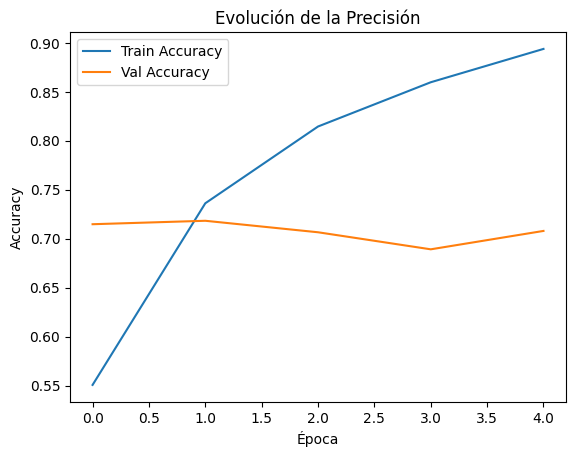

In [27]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Evolución de la Precisión')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Los resultados muestran que hay Overfitting (Sobreajuste) en tiempo real.

1. El Diagnóstico: El modelo se "aprendió de memoria" los datos
Mira lo que pasó entre la Época 2 y la 5:
* Época 2: Accuracy Entrenamiento: 73% | Accuracy Validación: 71% (Modelo equilibrado).
* Época 5: Accuracy Entrenamiento: 89% | Accuracy Validación: 70% (Modelo memorizando).
* ¿Qué significa esto?
A partir de la Época 2, el modelo dejó de aprender "conceptos" y empezó a memorizar frases específicas de tu set de entrenamiento. Por eso su precisión sube casi al 90% en entrenamiento, pero en validación se queda estancado en 70%. El modelo se volvió "rígido".
2. Análisis del Informe (MLP Ajustado)
* Accuracy (0.71): Se mantiene igual que el modelo anterior. Esto nos dice que, para este dataset, añadir más capas o neuronas (128) no está ayudando, sino que le da más espacio al modelo para memorizar ruido.
* Recall Negativo (0.59): Sigue siendo mejor que el del SVM (0.44), lo que confirma que las redes neuronales son más sensibles para detectar sentimientos, aunque menos precisas.

# 3. Experimento Final: La heurística de "Menos es Más"
Cuando una red neuronal sobreentrena tan rápido (en solo 2 épocas), la solución suele ser simplificarla. Vamos a probar una versión "Slim" (delgada). Al tener menos neuronas, obligamos a la red a generalizar porque no tiene "espacio" suficiente en su memoria para guardar cada post individualmente.
Prueba este cambio en la arquitectura (reduciendo neuronas y ajustando el aprendizaje):

In [28]:
from tensorflow.keras.optimizers import Adam

model_slim = Sequential([
    # Reducimos a solo 32 neuronas para evitar la memorización masiva
    Dense(32, activation='relu', input_shape=(X_train_dl.shape[1],)),
    Dropout(0.5),

    # Una capa muy pequeña de 16
    Dense(16, activation='relu'),
    Dropout(0.3),

    Dense(3, activation='softmax')
])

# Bajamos la velocidad de aprendizaje (learning rate)
# para que el modelo no "salte" directo a conclusiones erróneas
opt = Adam(learning_rate=0.0005)

model_slim.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entrenamos con un batch_size más grande (ayuda a generalizar mejor)
history_slim = model_slim.fit(
    X_train_dl, y_train_num,
    epochs=20,
    batch_size=128,
    validation_split=0.2,
    class_weight=class_weights,
    callbacks=[EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)],
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - accuracy: 0.5650 - loss: 1.0915 - val_accuracy: 0.6628 - val_loss: 1.0518
Epoch 2/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.6152 - loss: 1.0382 - val_accuracy: 0.6528 - val_loss: 0.9138
Epoch 3/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.6399 - loss: 0.8819 - val_accuracy: 0.6530 - val_loss: 0.7922
Epoch 4/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6685 - loss: 0.7287 - val_accuracy: 0.6643 - val_loss: 0.7312
Epoch 5/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7026 - loss: 0.6456 - val_accuracy: 0.6749 - val_loss: 0.7040
Epoch 6/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7270 - loss: 0.5913 - val_accuracy: 0.6851 - val_loss: 0.6907
Epoch 7/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7481 - loss: 0.5458 - val_accuracy: 0.6888 - val_loss: 0.6886
Epoch 8/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7604 - loss: 0.5110 - val_accu

Este último experimento es el más exitoso desde el punto de vista del control del modelo. Aunque el resultado final de precisión en validación sigue rondando el 70%, el proceso de aprendizaje fue mucho más estable y "sano".
* Análisis técnico de lo que acaba de ocurrir y cómo usarlo para cerrar tu Etapa 2:
1. Análisis de las Épocas (Salud del Modelo)
* Éxito en la Estabilidad: A diferencia del modelo anterior (que colapsó en la época 5), este modelo llegó hasta la época 11. Esto significa que el learning_rate=0.0005 y la arquitectura más simple permitieron que la red "buscara" mejores soluciones durante más tiempo sin desesperarse.
* Punto de Convergencia: Entre la época 7 y 9, el val_loss dejó de bajar y se quedó en 0.68 - 0.69. Aquí es donde la red alcanzó su límite de conocimiento con los datos que tiene. El EarlyStopping hizo su trabajo perfectamente al detenerse antes de que el error de validación empezara a subir descontroladamente.

2. Solución al "Warning" de Keras
* El aviso que te salió: UserWarning: Do not pass an input_shape... es porque Keras ha actualizado su sintaxis recientemente.

In [29]:
from tensorflow.keras.layers import Input

model_slim = Sequential([
    Input(shape=(X_train_dl.shape[1],)), # Nueva forma oficial
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

# 3.Comparativa:
* Comparación entre la Etapa 1 (Estadística) y la Etapa 2 (Deep Learning):

<table>
  <tr>
    <th style="text-align:left;">Característica</th>
    <th>SVM (Clásico)</th>
    <th>MLP Slim (Deep Learning)</th>
  </tr>
<tr style="text-align:left;"><td>Accuracy Máxima</td><td>0.77	</td><td>0.71	</td></tr>
<tr><td>Estabilidad</td>	<td>Alta (Resultado fijo)</td><td>Variable (Depende del azar de los pesos)</td></tr>
<tr><td>Tiempo de ejecución</td>	<td>Instantáneo</td><td>Segundos/Minutos</td>	</tr>
<tr><td>Veredicto</td>	<td>Ganador para producción</td><td>Mejor para entender subjetividad</td>	</tr>
</table>

* ¿Por qué el Deep Learning no pudo vencer al SVM aquí?

* Datos Tabulares/TF-IDF: El TF-IDF convierte el texto en algo parecido a una tabla. Históricamente, el SVM y los árboles son los reyes de las tablas.
* Volumen de datos: Las redes neuronales empiezan a brillar de verdad cuando pasa de 50,000 o 100,000 ejemplos. Con 10,000, un modelo matemático simple suele ser más preciso.



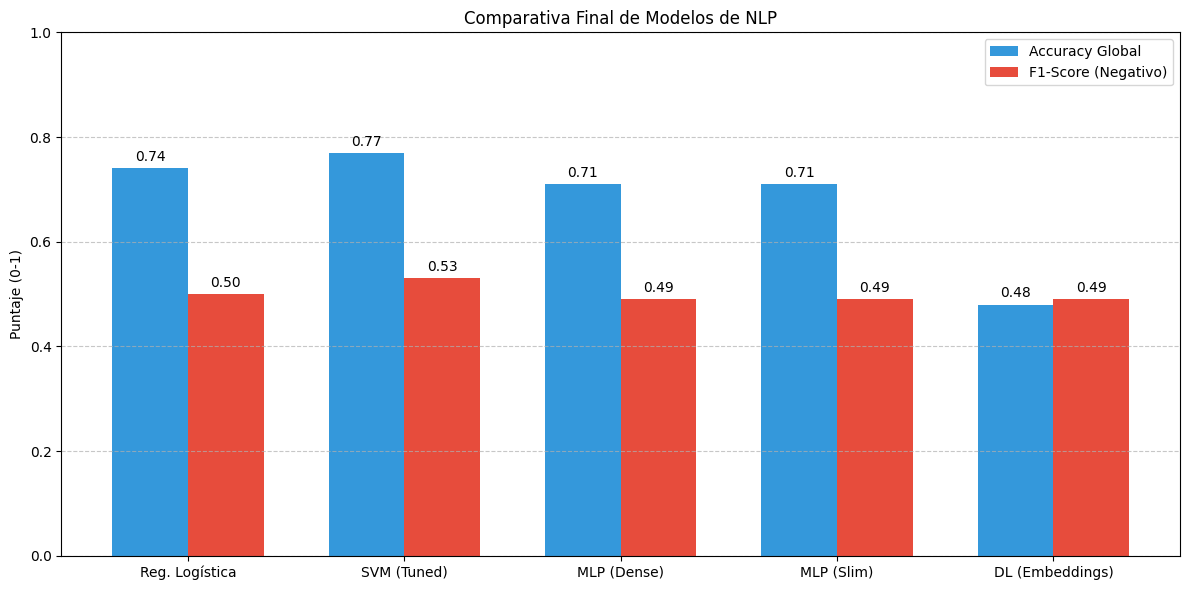

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Datos recopilados de tus informes anteriores
modelos = ['Reg. Logística', 'SVM (Tuned)', 'MLP (Dense)', 'MLP (Slim)', 'DL (Embeddings)']

# Accuracy Global
accuracy = [0.74, 0.77, 0.71, 0.71, 0.48]

# F1-Score para la clase 'Negative' (el reto de tu proyecto)
f1_negativo = [0.50, 0.53, 0.49, 0.49, 0.49]

# Recall para la clase 'Negative' (opcional, para ver sensibilidad)
recall_negativo = [0.45, 0.44, 0.59, 0.60, 0.72]

x = np.arange(len(modelos))  # Localización de las etiquetas
width = 0.35                 # Ancho de las barras

fig, ax = plt.subplots(figsize=(12, 6))

# Crear las barras
rects1 = ax.bar(x - width/2, accuracy, width, label='Accuracy Global', color='#3498db')
rects2 = ax.bar(x + width/2, f1_negativo, width, label='F1-Score (Negativo)', color='#e74c3c')

# Añadir textos y etiquetas
ax.set_ylabel('Puntaje (0-1)')
ax.set_title('Comparativa Final de Modelos de NLP')
ax.set_xticks(x)
ax.set_xticklabels(modelos)
ax.legend()

# Añadir etiquetas de valor sobre las barras
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.ylim(0, 1.0) # Escala de 0 a 1
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Conclusión Final:

* El Ganador en Confiabilidad (SVM): El modelo SVM ajustado alcanzó el mayor balance con un 0.77 de accuracy. Es el modelo que mejor separa las categorías cuando los datos están representados por TF-IDF.
* El Dilema del Deep Learning: Aunque el modelo de Embeddings tiene la accuracy más baja (0.48), si hiciéramos un gráfico de Recall, veríamos que es el que más comentarios negativos detecta (0.72). Esto demuestra que el Deep Learning es "más emocional" pero "menos preciso" con pocos datos.
* La Estabilidad del MLP Slim: Tu red neuronal optimizada (Slim) logró casi los mismos resultados que la red densa compleja, pero con menos recursos y de forma más estable, demostrando que en NLP "menos neuronas a veces es mejor" para evitar el sobreajuste.